In [1]:
pip install librosa soundfile numpy sklearn pyaudio

  Using cached librosa-0.10.0.post2-py3-none-any.whl (253 kB)
  Using cached soundfile-0.12.1-py2.py3-none-win_amd64.whl (1.0 MB)
                                              0.0/15.0 MB ? eta -:--:--
                                             0.0/15.0 MB 660.6 kB/s eta 0:00:23
                                             0.0/15.0 MB 660.6 kB/s eta 0:00:23
                                             0.0/15.0 MB 245.8 kB/s eta 0:01:01
                                             0.1/15.0 MB 438.1 kB/s eta 0:00:35
                                             0.1/15.0 MB 438.1 kB/s eta 0:00:35
                                             0.1/15.0 MB 438.1 kB/s eta 0:00:35
                                             0.1/15.0 MB 344.8 kB/s eta 0:00:44
                                             0.2/15.0 MB 382.3 kB/s eta 0:00:39
                                             0.2/15.0 MB 533.8 kB/s eta 0:00:28
                                             0.3/15.0 MB 609.2 kB/s eta 0:00:2

  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [18 lines of output]
  The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
  rather than 'sklearn' for pip commands.
  
  Here is how to fix this error in the main use cases:
  - use 'pip install scikit-learn' rather than 'pip install sklearn'
  - replace 'sklearn' by 'scikit-learn' in your pip requirements files
    (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
  - if the 'sklearn' package is used by one of your dependencies,
    it would be great if you take some time to track which package uses
    'sklearn' instead of 'scikit-learn' and report it to their issue tracker
  - as a last resort, set the environment variable
    SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
  
  More information is available at
  https://github.com/scikit-learn/sklearn-pypi-package
  
  If the previous advice does not cover your use case, feel 

In [3]:
pip install sounddevice soundfile

                                              0.0/199.7 kB ? eta -:--:--
     ------------------------------------- 199.7/199.7 kB 11.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install librosa

  Using cached librosa-0.10.0.post2-py3-none-any.whl (253 kB)
  Using cached audioread-3.0.0.tar.gz (377 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached numpy-1.25.0-cp311-cp311-win_amd64.whl (15.0 MB)
                                              0.0/42.2 MB ? eta -:--:--
                                              0.1/42.2 MB 1.7 MB/s eta 0:00:26
                                              0.2/42.2 MB 2.1 MB/s eta 0:00:21
                                              0.3/42.2 MB 2.6 MB/s eta 0:00:16
                                              0.4/42.2 MB 2.5 MB/s eta 0:00:17
                                              0.7/42.2 MB 2.8 MB/s eta 0:00:15
                                              0.8/42.2 MB 2.9 MB/s eta 0:00:15
                                              1.0/42.2 MB 3.0 MB/s eta 0:00:14
     -                                        1.3/42.2 MB 3.3 MB/s eta 0:00:13
     -               

In [2]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [3]:
# Extract features
def extract_feature(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        if chroma:
            stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, mel))
        return result

In [4]:
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

#Emotions to observe
observed_emotions=['calm', 'happy','sad','angry','fearful']

In [5]:
def load_data(test_size=0.2):
    x,y=[],[]
    for file in glob.glob("M:\Audio_Song_Actors_01-24\Actor_*\*.wav"):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(emotion)
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

In [6]:
#Split the dataset
x_train,x_test,y_train,y_test=load_data(test_size=0.25)

In [7]:
#Get the shape of the training and testing datasets
print((x_train.shape[0], x_test.shape[0]))

(690, 230)


In [8]:
#Get the number of features extracted
print(f'Features extracted: {x_train.shape[1]}')

Features extracted: 180


In [9]:
#Initialize the Multi Layer Perceptron Classifier
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=1000)

In [10]:
#Train the model
model.fit(x_train,y_train)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=1000)

In [11]:
#Predict for the test set
y_pred=model.predict(x_test)

In [12]:
#Calculate the accuracy of our model
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)

#DataFlair - Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 88.70%


In [13]:
def predict_emotion(file_path):
    # Extract features from the file
    features = extract_feature(file_path, mfcc=True, chroma=True, mel=True)
    
    # Reshape the features to match the shape expected by the model
    features = features.reshape(1, -1)
    
    # Predict the emotion using the trained model
    predicted_emotion = model.predict(features)
    
    return predicted_emotion[0]

In [14]:
file_path = "M:\\mini_p_audio\\Actor_17\\03-01-03-01-02-01-17.wav"

# Predict the emotion for the external file
predicted_emotion = predict_emotion(file_path)

# Print the predicted emotion
print("Predicted Emotion: ", predicted_emotion)

Predicted Emotion:  happy


In [59]:
pip install pyttsx3

In [20]:
pip install matplotlib seaborn

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [16]:

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


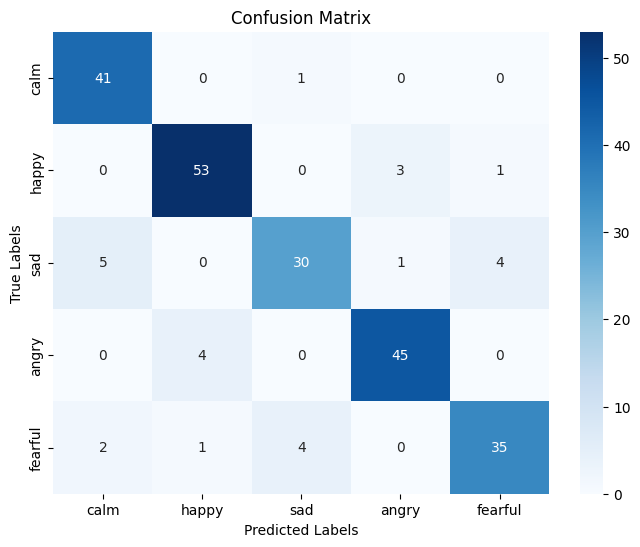

In [17]:
plot_confusion_matrix(y_test, y_pred, observed_emotions)

In [18]:
def plot_training_history(loss_curve):
    epochs = range(1, len(loss_curve) + 1)

    plt.figure(figsize=(12, 6))

    # Plot loss
    plt.plot(epochs, loss_curve, 'r', label='Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()


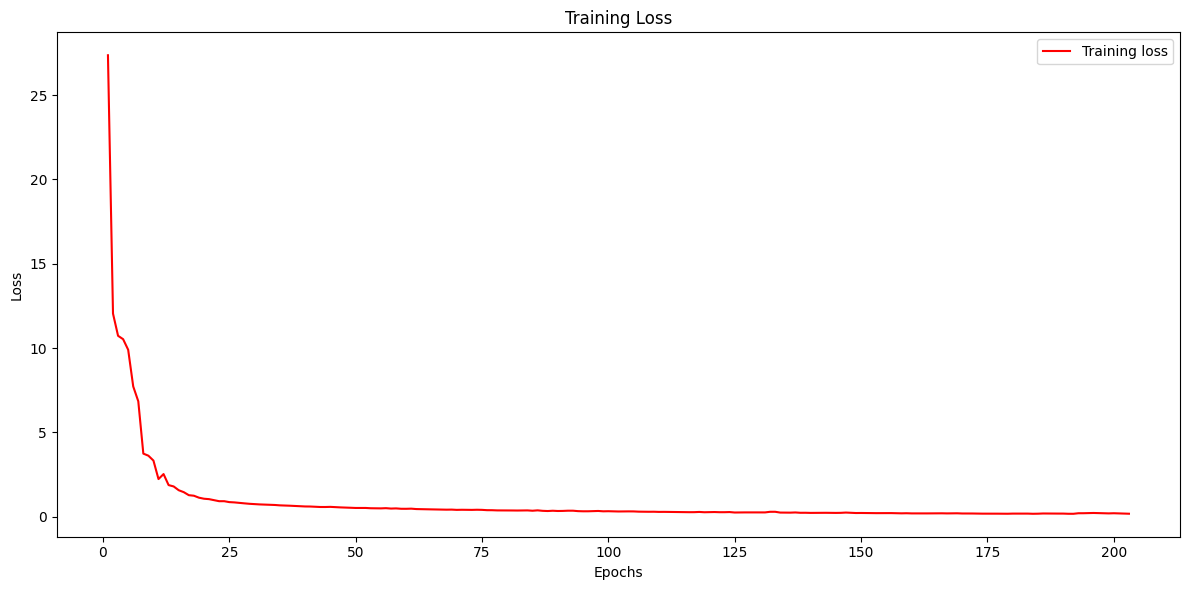

In [19]:
plot_training_history(model.loss_curve_)

In [20]:
import tkinter as tk
import tkinter.messagebox as messagebox
import sounddevice as sd
import soundfile as sf
from tkinter import filedialog
import pyttsx3

In [21]:
def chatbot(emotion):     
    if emotion == "calm":
        return "You sound calm. have a nice day and relax."
    elif emotion == "happy":
        return "You sound happy. Keep smiling and enjoy your day!"
    elif emotion == "sad":
        return "You sound sad. It's okay to feel down sometimes. Reach out to someone for support."
    elif emotion == "angry":
        return "You sound angry. Take a moment to cool down and express your emotions constructively."
    elif emotion == "fearful":
        return "You sound fearful. Remember that fear is a natural response, but try to face your fears."
    elif emotion == "disgust":
        return "You sound disgusted. Sometimes things can be unpleasant, but look for the positive aspects."
    elif emotion == "surprised":
        return "You sound surprised. Life is full of unexpected moments. Embrace the surprises!"
    else:
        return "I'm not sure how to respond to that emotion. Can you please elaborate?"
        

In [ ]:
# Define the GUI class
class EmotionPredictionGUI:
    def __init__(self):
        self.window = tk.Tk()
        self.window.title("Emotion Prediction")
        self.window.geometry("400x200")
        # Record button
        self.record_button = tk.Button(self.window, text="Record", command=self.record_speech, bg="blue", fg="white", font=("Arial", 14, "bold"), relief="raised")
        self.record_button.pack(pady=30)
#         self.record_button.pack(pady=10)
        self.file_button = tk.Button(self.window, text="Select File", command=self.select_file, bg="green", fg="white", font=("Arial", 14, "bold"), relief="raised")
        self.file_button.pack(pady=10)
        
        self.engine = pyttsx3.init()
        self.engine.setProperty("rate", 150)
        
        self.window.mainloop()
        
        

        # Speak the response
        self.engine.say(response)
        self.engine.runAndWait()
    
    # Function to record speech
    def record_speech(self):
        # Configure the recording parameters
        sample_rate = 16000  # Sample rate of the audio
        duration = 3  # Duration of the recording in seconds
        
        # Record the speech
        messagebox.showinfo("Recording", "Recording started. Please speak for {} seconds.".format(duration))
        audio = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=1)
        sd.wait()
        
        # Save the recorded speech to a file
        file_path = "recorded_speech.wav"
        sf.write(file_path, audio, sample_rate)
        
        # Predict the emotion for the recorded speech
        predicted_emotion = predict_emotion(file_path)
        
        # Show the predicted emotion in a message box
        
        response = chatbot(predicted_emotion)
        
        messagebox.showinfo("Emotion Prediction", "Predicted Emotion: {}".format(predicted_emotion))
        
        self.engine.say(response)
        self.engine.runAndWait()
        
    def select_file(self):
        # Open a file dialog to select a file
        file_path = filedialog.askopenfilename(title="Select Audio File", filetypes=[("Audio Files", "*.wav")])
        
        if file_path:
            # Predict the emotion for the selected file
            predicted_emotion = predict_emotion(file_path)
            
            response = chatbot(predicted_emotion)
            
            # Show the predicted emotion in a message box
            messagebox.showinfo("Emotion Prediction", "Predicted Emotion: {}".format(predicted_emotion))
        
            self.engine.say(response)
            self.engine.runAndWait()
            

# Create an instance of the GUI class
gui = EmotionPredictionGUI()
